In [1]:
#Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

# Данный нотбук отражает предобработку данных. Построение моделей изложено в нотбуке "Models on Tinkoff"

In [2]:
cr_df = pd.read_csv("C:/Users/Xiaomi/Desktop/Data/credit_train.csv", sep = ';', encoding='ANSI', decimal = ',')
cr_df2 = pd.read_csv("C:/Users/Xiaomi/Desktop/Data/credit_train.csv", sep = ';', encoding='ANSI', decimal = ',')
df_copy = pd.read_csv("C:/Users/Xiaomi/Desktop/Data/credit_train.csv", sep = ';', encoding='ANSI', decimal = ',')

In [3]:
#Посмотрим на размер датафрейма
cr_df.shape

(170746, 15)

In [4]:
#Посмотрим на небольшую сводку, которая отражает типы данных и количество наблюдений
cr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 15 columns):
client_id               170746 non-null int64
gender                  170746 non-null object
age                     170743 non-null float64
marital_status          170743 non-null object
job_position            170746 non-null object
credit_sum              170744 non-null float64
credit_month            170746 non-null int64
tariff_id               170746 non-null object
score_shk               170739 non-null float64
education               170741 non-null object
living_region           170554 non-null object
monthly_income          170741 non-null float64
credit_count            161516 non-null float64
overdue_credit_count    161516 non-null float64
open_account_flg        170746 non-null int64
dtypes: float64(6), int64(3), object(6)
memory usage: 19.5+ MB


In [5]:
#Создадим сводку, которая бы отражала количество пропущенных значений по столбцам и % который они составляют
total = cr_df.isnull().sum().sort_values(ascending = False)
percent = (cr_df.isnull().sum() / cr_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total missing values', 'Percent %'])
missing_data

,Total missing values,Percent %
overdue_credit_count,9230,0.054057
credit_count,9230,0.054057
living_region,192,0.001124
score_shk,7,0.000041
monthly_income,5,0.000029
education,5,0.000029
marital_status,3,0.000018
age,3,0.000018
credit_sum,2,0.000012
open_account_flg,0,0.000000


# Анализ числовых признаков на выбросы

In [6]:
#Выведем список всех числовых признаков (age, credit_sum, credit_month, score_shk, monthly_income, credit_count,
#overdue_credit_count)
list(cr_df.select_dtypes(include = 'float'))

['age',
 'credit_sum',
 'score_shk',
 'monthly_income',
 'credit_count',
 'overdue_credit_count']

In [7]:
list(cr_df.select_dtypes(include = 'int64'))

['client_id', 'credit_month', 'open_account_flg']

Безопасности ради я создал отдельный датафрейм под названием cr_df2, он является полной копией исходного датафрейма cr_df, который мы пока оставим до лучших времен.

# Квартили распределения и выбросы

Все что превышает +-1,5 межквартильного размаха является выбросом, если же происходит превышение +-3 межквартильных размаха, то данное значение является экстремальным. 

## Возраст

In [8]:
#Выведем общие статистические показатели по признаку age
cr_df2['age'].describe()

count    170743.000000
mean         36.497262
std          10.546044
min          18.000000
25%          28.000000
50%          34.000000
75%          43.000000
max          71.000000
Name: age, dtype: float64

In [9]:
age_data = cr_df2['age']

In [10]:
#Создадим функцию, которая бы выводила границы +-1.5 межквартильного размаха
def quartiles(x):
 q1, q3 = np.percentile(x, [25, 75])
 iqr = q3 - q1
 lower_bound = q1 - (iqr * 1.5)
 upper_bound = q3 + (iqr * 1.5)
 return lower_bound, upper_bound 

In [11]:
quartiles(age_data.dropna())

(5.5, 65.5)

In [12]:
# Посмотрим сколько клиентов старше 65 лет
more_65_years = cr_df2[cr_df2['age']>65]

In [13]:
# Итого 1322 клиента старше 65 лет
more_65_years.shape

(1322, 15)

In [14]:
# Найдем долю в % людей старше 65 лет
more_65_years_percent = (1322 * 100) / 170746
print("Доля людей старше 65 лет: {:.2f} %".format(more_65_years_percent))
#Таким образом люди старше 65 лет составляют менее 1% клиентов.

Доля людей старше 65 лет: 0.77 %


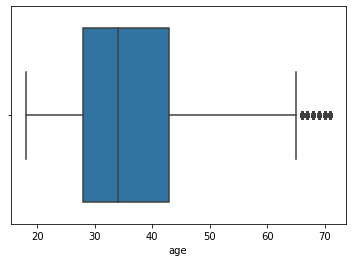

In [15]:
sns.boxplot(age_data.dropna());

### Вывод: 


Возраст должен быть < 65.5

## Сумма кредита

In [16]:
cr_df2['credit_sum'].describe()

count    170744.000000
mean      26095.097541
std       16234.874095
min        2736.000000
25%       14908.000000
50%       21229.000000
75%       32068.000000
max      200000.000000
Name: credit_sum, dtype: float64

In [17]:
credit_sum_data = cr_df2['credit_sum']

In [18]:
quartiles(credit_sum_data.dropna())

(-10832.0, 57808.0)

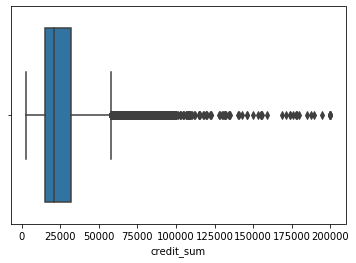

In [19]:
sns.boxplot(credit_sum_data.dropna());

In [20]:
# Посчитаем какую долю в % имеют клиенты с суммой кредита свыше  57808
more_57808_credit_sum = cr_df2[cr_df2['credit_sum'] > 57808]
more_57808_credit_sum.shape

(10103, 15)

In [21]:
cr_df2.shape

(170746, 15)

In [22]:
more_57808_credit_sum_percent = 10103 * 100 / 170746
print("Доля клиентов с суммой кредита свыше  57808 рублей: {:.2f} %".format(more_57808_credit_sum_percent))

Доля клиентов с суммой кредита свыше  57808 рублей: 5.92 %


### Вывод

Сумма кредита < 57808

### Срок кредитования

In [23]:
cr_df2['credit_month'].describe()

count    170746.000000
mean         10.980749
std           3.536698
min           3.000000
25%          10.000000
50%          10.000000
75%          12.000000
max          36.000000
Name: credit_month, dtype: float64

In [24]:
credit_month_data = cr_df2['credit_month']

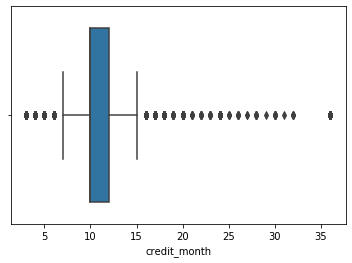

In [25]:
sns.boxplot(credit_month_data.dropna());

In [26]:
quartiles(credit_month_data.dropna())

(7.0, 15.0)

In [27]:
less_7_month = cr_df2[cr_df2['credit_month']<7]
more_15_month = cr_df2[cr_df2['credit_month']>15]

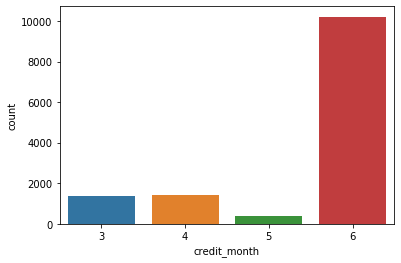

In [28]:
sns.countplot(less_7_month['credit_month']);

In [29]:
less_7_month.shape

(13353, 15)

In [30]:
less_7_month_percent = 13353 * 100 / 170746
print("Доля клиентов со сроком кредитования менее чем 7 месяцев: {:.2f}%".format(less_7_month_percent))

Доля клиентов со сроком кредитования менее чем 7 месяцев: 7.82%


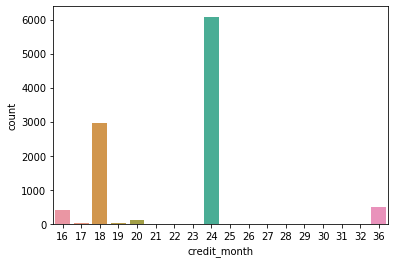

In [31]:
sns.countplot(more_15_month['credit_month']);

In [32]:
more_15_month.shape

(10173, 15)

In [33]:
more_15_month_percent = 10173 * 100 / 170746
print("Доля клиентов со сроком кредитования свыше 15 месяцев: {:.2f}%".format(more_15_month_percent))

Доля клиентов со сроком кредитования свыше 15 месяцев: 5.96%


### Вывод: 

Срок кредитования лежит в промежутке 7<x<15 месяцев

## Скоринговая оценка

In [34]:
cr_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 15 columns):
client_id               170746 non-null int64
gender                  170746 non-null object
age                     170743 non-null float64
marital_status          170743 non-null object
job_position            170746 non-null object
credit_sum              170744 non-null float64
credit_month            170746 non-null int64
tariff_id               170746 non-null object
score_shk               170739 non-null float64
education               170741 non-null object
living_region           170554 non-null object
monthly_income          170741 non-null float64
credit_count            161516 non-null float64
overdue_credit_count    161516 non-null float64
open_account_flg        170746 non-null int64
dtypes: float64(6), int64(3), object(6)
memory usage: 19.5+ MB


In [35]:
cr_df2['score_shk'].describe()

count    170739.000000
mean          0.469473
std           0.124265
min           0.000000
25%           0.379522
50%           0.461599
75%           0.552412
max           1.128291
Name: score_shk, dtype: float64

In [36]:
score_shk_data = cr_df2['score_shk']

In [37]:
quartiles(score_shk_data.dropna())

(0.12018774999999987, 0.8117457500000002)

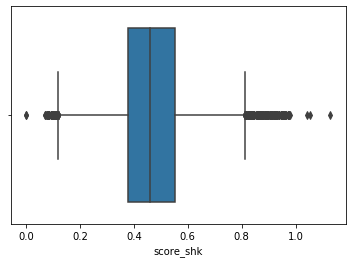

In [38]:
sns.boxplot(score_shk_data.dropna());

In [39]:
less_than_min_score_shk = cr_df2[cr_df2['score_shk']<0.12018774999999987]
less_than_min_score_shk.shape

(72, 15)

In [40]:
less_than_min_score_shk_percent = 72 * 100 / 170746
print("Доля клиентов с кредитным рейтингом ниже чем значения -1,5 межквартильного размаха: {:.2f}%".format(less_than_min_score_shk_percent))

Доля клиентов с кредитным рейтингом ниже чем значения -1,5 межквартильного размаха: 0.04%


In [41]:
more_than_max_score_shk = cr_df2[cr_df2['score_shk']>0.8117457500000002]
print(more_than_max_score_shk.shape)
more_than_max_score_shk_percent = 171 * 100 / 170746
print("Доля клиентов с кредитным рейтингом ниже чем значение +1,5 межквартильного размаха: {:.2f}%".format(more_than_max_score_shk_percent))

(171, 15)
Доля клиентов с кредитным рейтингом ниже чем значение +1,5 межквартильного размаха: 0.10%


### Вывод:

Внутренний скоринговый рейтинг должен лежать в диапазоне 0.12018774999999987 < x < 0.8117457500000002 

## Ежемесячный доход

In [42]:
cr_df2['monthly_income'].describe()

count    170741.000000
mean      40138.596149
std       25044.373992
min        5000.000000
25%       25000.000000
50%       35000.000000
75%       50000.000000
max      950000.000000
Name: monthly_income, dtype: float64

In [43]:
monthly_income_data = cr_df2['monthly_income']

In [44]:
quartiles(monthly_income_data.dropna())

(-12500.0, 87500.0)

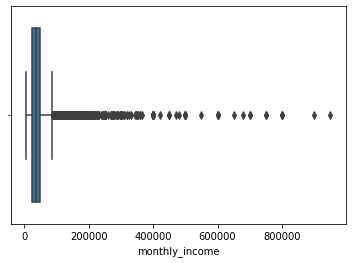

In [45]:
sns.boxplot(monthly_income_data.dropna());

In [46]:
more_87500_income = cr_df2[cr_df2['monthly_income']>87500]
print(more_87500_income.shape)
more_87500_income_percent = 6806 * 100 / 170746
print("Доля клиентов с доходом свыше 87500 тысяч рублей в месяц: {:.2f}%".format(more_87500_income_percent))

(6806, 15)
Доля клиентов с доходом свыше 87500 тысяч рублей в месяц: 3.99%


## Вывод:

Ежемесячный доход должен быть < 87500, иначе уже считается как выброс.

## Количество кредитов у клиента

In [47]:
cr_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 15 columns):
client_id               170746 non-null int64
gender                  170746 non-null object
age                     170743 non-null float64
marital_status          170743 non-null object
job_position            170746 non-null object
credit_sum              170744 non-null float64
credit_month            170746 non-null int64
tariff_id               170746 non-null object
score_shk               170739 non-null float64
education               170741 non-null object
living_region           170554 non-null object
monthly_income          170741 non-null float64
credit_count            161516 non-null float64
overdue_credit_count    161516 non-null float64
open_account_flg        170746 non-null int64
dtypes: float64(6), int64(3), object(6)
memory usage: 19.5+ MB


In [48]:
cr_df2['credit_count'].describe()

count    161516.000000
mean          2.107308
std           1.777128
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          21.000000
Name: credit_count, dtype: float64

In [49]:
credit_count_data = cr_df2['credit_count']

In [50]:
quartiles(credit_count_data.dropna())

(-2.0, 6.0)

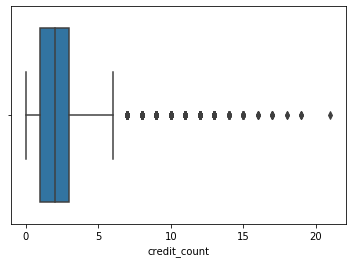

In [51]:
sns.boxplot(credit_count_data.dropna());

In [52]:
more_six_credit = cr_df2[cr_df2['credit_count']>6]
more_six_credit.shape


(3944, 15)

In [53]:
more_six_credit_percent = 3944 * 100 / 170746
print("Доля клиентов с количеством кредитов больше чем 6: {:.2f}%".format(more_six_credit_percent))

Доля клиентов с количеством кредитов больше чем 6: 2.31%


### Вывод:

Количество действующих кредитов клиента > 6 считается за выброс (порог  x < 6)

## Количество просроченных кредитов

In [54]:
cr_df2['overdue_credit_count'].describe()

count    161516.000000
mean          0.046070
std           0.211548
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.000000
Name: overdue_credit_count, dtype: float64

In [55]:
overdue_credit_count_data = cr_df2['overdue_credit_count']

In [56]:
quartiles(overdue_credit_count_data.dropna())

(0.0, 0.0)

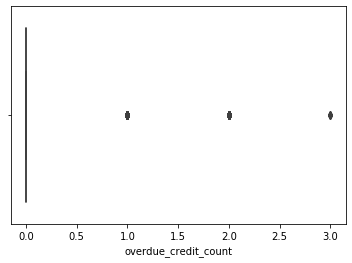

In [57]:
sns.boxplot(overdue_credit_count_data.dropna());

In [58]:
have_overdue_credit = cr_df2[cr_df2['overdue_credit_count']>0]
have_overdue_credit.shape

(7381, 15)

In [59]:
have_overdue_credit_percent = 7381 * 100 / 170746
print("Доля клиентов имеющих просроченные кредиты: {:.2f}%".format(have_overdue_credit_percent))

Доля клиентов имеющих просроченные кредиты: 4.32%


### Вывод:

Количество просроченных кредитов != 0 считается выбросом.

# Удаление выбросов

In [60]:
#Пока сделаем копию данных cr_df2, чтобы ее не испортить и в последствии к ней вернуться. 
#Поработаем с ее копиями, после чего уже примененим методы к исходному датафрейму.
cr_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 15 columns):
client_id               170746 non-null int64
gender                  170746 non-null object
age                     170743 non-null float64
marital_status          170743 non-null object
job_position            170746 non-null object
credit_sum              170744 non-null float64
credit_month            170746 non-null int64
tariff_id               170746 non-null object
score_shk               170739 non-null float64
education               170741 non-null object
living_region           170554 non-null object
monthly_income          170741 non-null float64
credit_count            161516 non-null float64
overdue_credit_count    161516 non-null float64
open_account_flg        170746 non-null int64
dtypes: float64(6), int64(3), object(6)
memory usage: 19.5+ MB


In [61]:
df4 = cr_df2.copy(deep=True)

In [62]:
df4.shape

(170746, 15)

In [63]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 15 columns):
client_id               170746 non-null int64
gender                  170746 non-null object
age                     170743 non-null float64
marital_status          170743 non-null object
job_position            170746 non-null object
credit_sum              170744 non-null float64
credit_month            170746 non-null int64
tariff_id               170746 non-null object
score_shk               170739 non-null float64
education               170741 non-null object
living_region           170554 non-null object
monthly_income          170741 non-null float64
credit_count            161516 non-null float64
overdue_credit_count    161516 non-null float64
open_account_flg        170746 non-null int64
dtypes: float64(6), int64(3), object(6)
memory usage: 19.5+ MB


In [64]:
#Напишем цикл, который все пропущенные значения в числовых признаках заполняет -999, а в текстовых или категориальных no_info
for col in df4:
    if df4[col].dtypes == 'float':
        df4[col] = df4[col].fillna(-999)
    elif df4[col].dtypes == 'int':
        df4[col] = df4[col].fillna(-999)
    else:
        df4[col] = df4[col].fillna('no_info')

In [65]:
df4.isnull().sum()

client_id               0
gender                  0
age                     0
marital_status          0
job_position            0
credit_sum              0
credit_month            0
tariff_id               0
score_shk               0
education               0
living_region           0
monthly_income          0
credit_count            0
overdue_credit_count    0
open_account_flg        0
dtype: int64

Еще раз напомню некую безопасную область, которая будет отсекать выбросы: 
- Возраст: должен быть < 65.5
- Сумма кредита: должна быть < 57808
- Срок кредитования: лежит в промежутке 7 < x < 15 месяцев
- Скоринговый рейтинг: внутренний скоринговый рейтинг должен лежать в диапазоне 0.12018774999999987 < x < 0.8117457500000002
- Ежемесячный доход: должен быть < 87500
- Количество действующих кредитов: должно быть < 6 
- Количество просроченных кредитов: = 0

In [66]:
#Удалим выбросы отсекая заданные пороги.
df4 = df4[df4['age']<65.5]
df4.shape

(169424, 15)

In [67]:
df4 = df4[df4['credit_sum']<57808]
df4 = df4[df4['credit_month']>7]
df4 = df4[df4['credit_month']<15]
df4 = df4[df4['score_shk']>0.12018774999999987]
df4 = df4[df4['score_shk']<0.8117457500000002]
df4 = df4[df4['monthly_income']<87500]
df4 = df4[df4['credit_count']<6]
df4 =df4[df4['overdue_credit_count']==0]

In [68]:
#Посмотрим на количество оставшихся наблюдений
df4.shape

(115013, 15)

In [69]:
df4.tail()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
170739,170740,F,32.0,MAR,SPC,15282.00,10,1.16,0.514811,GRD,САМАРСКАЯ ОБЛАСТЬ,25000.0,2.0,0.0,0
170740,170741,F,24.0,UNM,SPC,19818.00,12,1.6,0.624391,SCH,КРАСНОДАРСКИЙ КРАЙ,22000.0,1.0,0.0,0
170743,170744,F,31.0,UNM,SPC,27556.47,10,1.32,0.416098,GRD,ПРИМОРСКИЙ КРАЙ,40000.0,1.0,0.0,0
170744,170745,F,53.0,DIV,PNA,6189.00,12,1.1,0.482595,SCH,ПЕНЗЕНСКАЯ ОБЛ,31000.0,2.0,0.0,0
170745,170746,M,49.0,MAR,SPC,12787.00,10,1.1,0.316087,GRD,ОБЛ МОСКОВСКАЯ,40000.0,3.0,0.0,0


In [70]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115013 entries, 4 to 170745
Data columns (total 15 columns):
client_id               115013 non-null int64
gender                  115013 non-null object
age                     115013 non-null float64
marital_status          115013 non-null object
job_position            115013 non-null object
credit_sum              115013 non-null float64
credit_month            115013 non-null int64
tariff_id               115013 non-null object
score_shk               115013 non-null float64
education               115013 non-null object
living_region           115013 non-null object
monthly_income          115013 non-null float64
credit_count            115013 non-null float64
overdue_credit_count    115013 non-null float64
open_account_flg        115013 non-null int64
dtypes: float64(6), int64(3), object(6)
memory usage: 14.0+ MB


In [71]:
#Приравняем датафрейм cr_df2 к df4
cr_df2 = df4.copy(deep = True)

In [72]:
cr_df2.shape

(115013, 15)

In [73]:
cr_df2.isnull().sum()

client_id               0
gender                  0
age                     0
marital_status          0
job_position            0
credit_sum              0
credit_month            0
tariff_id               0
score_shk               0
education               0
living_region           0
monthly_income          0
credit_count            0
overdue_credit_count    0
open_account_flg        0
dtype: int64

# Обработка категориальных переменных

In [74]:
# Выведем список всех категориальных переменных
list(cr_df2.select_dtypes(include = 'object'))

['gender',
 'marital_status',
 'job_position',
 'tariff_id',
 'education',
 'living_region']

## Обработка признака living_region

In [75]:
#В России всего 85 субъектов, таким образом столбец региона должен содержать в себе максимум 85 уникальных значений.
cr_df2['living_region'].nunique()

270

In [76]:
#Увеличим количество отображаемых строк
pd.options.display.max_rows = 310

In [77]:
#Создадим Series, которая будет содержать в себе все уникальные значения регионов по нашему датафрейму.
regions = cr_df2['living_region'].unique()
regions = pd.Series(data = regions, index = regions, name = 'regions')

In [78]:
type(regions)

pandas.core.series.Series

In [79]:
regions

ЧЕЛЯБИНСКАЯ ОБЛАСТЬ                                              ЧЕЛЯБИНСКАЯ ОБЛАСТЬ
МОСКОВСКАЯ ОБЛ                                                        МОСКОВСКАЯ ОБЛ
САНКТ-ПЕТЕРБУРГ                                                      САНКТ-ПЕТЕРБУРГ
РЕСП. БАШКОРТОСТАН                                                РЕСП. БАШКОРТОСТАН
ОБЛ АРХАНГЕЛЬСКАЯ                                                  ОБЛ АРХАНГЕЛЬСКАЯ
РЕСП БАШКОРТОСТАН                                                  РЕСП БАШКОРТОСТАН
ПЕРМСКИЙ КРАЙ                                                          ПЕРМСКИЙ КРАЙ
КРАСНОДАРСКИЙ КРАЙ                                                КРАСНОДАРСКИЙ КРАЙ
ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА    ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА
РЕСП КАРАЧАЕВО-ЧЕРКЕССКАЯ                                  РЕСП КАРАЧАЕВО-ЧЕРКЕССКАЯ
САРАТОВСКАЯ ОБЛ                                                      САРАТОВСКАЯ ОБЛ
ОБЛ ВОЛОГОДСКАЯ                                                  

In [80]:
#Создадим стоп-слова
stopwrds = set(['ОБЛ','ОБЛАСТЬ', 'РЕСП', 'РЕСПУБЛИКА', 
                'КРАЙ', 'Г', 'АО', 'АОБЛ', 'АВТОНОМНАЯ'])

In [81]:
#Создадим функцию, которая будет удалять из записей точки и запятые и разбивать на отдельные слова, затем зададим проверку на наличие в stopwords
def clean_region(x):
    x = re.sub('[.,]+', ' ', str(x))
    wrds = x.split(' ')
    wrds_new = []
    for w in wrds:
        if not w in stopwrds:
            wrds_new.append(w)
    x = ''.join(wrds_new)
    return x

In [82]:
regions = regions.map(clean_region)

In [83]:
regions

ЧЕЛЯБИНСКАЯ ОБЛАСТЬ                                                  ЧЕЛЯБИНСКАЯ
МОСКОВСКАЯ ОБЛ                                                        МОСКОВСКАЯ
САНКТ-ПЕТЕРБУРГ                                                  САНКТ-ПЕТЕРБУРГ
РЕСП. БАШКОРТОСТАН                                                  БАШКОРТОСТАН
ОБЛ АРХАНГЕЛЬСКАЯ                                                  АРХАНГЕЛЬСКАЯ
РЕСП БАШКОРТОСТАН                                                   БАШКОРТОСТАН
ПЕРМСКИЙ КРАЙ                                                           ПЕРМСКИЙ
КРАСНОДАРСКИЙ КРАЙ                                                 КРАСНОДАРСКИЙ
ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА    ХАНТЫ-МАНСИЙСКИЙАВТОНОМНЫЙОКРУГ-ЮГРА
РЕСП КАРАЧАЕВО-ЧЕРКЕССКАЯ                                   КАРАЧАЕВО-ЧЕРКЕССКАЯ
САРАТОВСКАЯ ОБЛ                                                      САРАТОВСКАЯ
ОБЛ ВОЛОГОДСКАЯ                                                      ВОЛОГОДСКАЯ
УДМУРТСКАЯ РЕСП             

In [84]:
regions['ЧУКОТСКИЙ АO'] = 'ЧУКОТСКИЙ'
regions['ЧУВАШСКАЯ РЕСПУБЛИКА - ЧУВАШИЯ'] = 'ЧУВАШСКАЯ'
regions['ЧУВАШИЯ ЧУВАШСКАЯ РЕСПУБЛИКА -'] = 'ЧУВАШСКАЯ'
regions['ЧУВАШСКАЯ - ЧУВАШИЯ РЕСП'] = 'ЧУВАШСКАЯ'
regions['РЕСП ЧУВАШСКАЯ - ЧУВАШИЯ'] = 'ЧУВАШСКАЯ'
regions['ЧУВАШСКАЯ - ЧУВАШИЯ РЕСП'] = 'ЧУВАШСКАЯ'
regions['РЕСПУБЛИКАТАТАРСТАН'] = 'ТАТАРСТАН'
regions['ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ'] = 'МОСКОВСКАЯ'
regions['ПЕРМСКАЯ ОБЛ'] = 'ПЕРМСКИЙ'
regions['ОРЁЛ'] = 'ОРЛОВСКАЯ'
regions['Г.ОДИНЦОВО МОСКОВСКАЯ ОБЛ'] = 'МОСКОВСКАЯ'
regions['МЫТИЩИНСКИЙ Р-Н'] = 'МОСКОВСКАЯ'
regions['МОСКОВСКИЙ П'] = 'МОСКОВСКАЯ'
regions['КАМЧАТСКАЯ ОБЛАСТЬ'] = 'КАМЧАТСКИЙ'
regions['ДАЛЬНИЙ ВОСТОК'] = 'МОСКОВСКАЯ'
regions['ДАЛЬНИЙВОСТОК'] = 'МОСКОВСКАЯ'
regions['ГУСЬ-ХРУСТАЛЬНЫЙ Р-Н'] = 'ВЛАДИМИРСКАЯ'
regions['ГОРЬКОВСКАЯ ОБЛ'] = 'НИЖЕГОРОДСКАЯ'
regions['ЭВЕНКИЙСКИЙ АО'] = 'КРАСНОЯРСКИЙ'
regions['ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions['АО ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - Ю'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions['АО ХАНТЫ-МАНСИЙСКИЙ-ЮГРА'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions['СЕВ. ОСЕТИЯ - АЛАНИЯ'] = 'СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ'
regions['РЕСП. САХА (ЯКУТИЯ)'] ='САХА/ЯКУТИЯ/'
regions['РЕСПУБЛИКА САХА'] = 'САХА/ЯКУТИЯ/'
regions['ДАЛЬНИЙВОСТОК'] = 'МОСКОВСКАЯ'
regions['САХА'] = 'САХА/ЯКУТИЯ/'
regions['98'] = 'САНКТ-ПЕТЕРБУРГ'
regions['74'] = 'ЧЕЛЯБИНСКАЯ'
regions['РОССИЯ'] = 'МОСКОВСКАЯ'
regions['МОСКВОСКАЯ'] = 'МОСКОВСКАЯ'
regions['МОСКВОСКАЯ ОБЛ'] = 'МОСКОВСКАЯ'
regions['ЧЕЛЯБИНСК'] = 'ЧЕЛЯБИНСКАЯ'
regions['Г. ЧЕЛЯБИНСК'] = 'ЧЕЛЯБИНСКАЯ'
regions['БРЯНСКИЙ'] = 'БРЯНСКАЯ'

In [85]:
#Проверим признак living_region на уникальные значения, их должно быть 85
regions.nunique()

85

In [86]:
#Заменим наш обработанный признак региона в датафрейме cr_df2
cr_df2['living_region'] = cr_df2['living_region'].map(regions)

In [87]:
cr_df2['living_region'].nunique()

85

## Обработка признака gender

In [88]:
#Признак gender содержит в себе всего лишь 2 уникальных значения, 
#которые в дальнейшем можно будет обработать с помощью one-hot кодирования,
#или же просто заменить на 0 и 1 в соотвествующем признаке, так как уникальных значений всего 2 и можно обойтись и этим.
cr_df2['gender'].nunique()

2

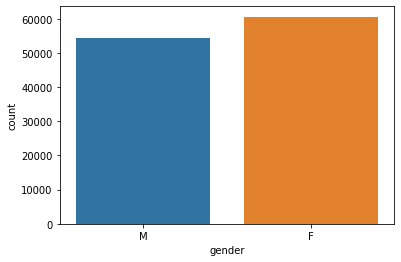

In [89]:
sns.countplot(cr_df2['gender']);

In [90]:
genders = {'M': 0, 'F': 1}

In [91]:
cr_df2['gender'] = cr_df2['gender'].replace(genders)

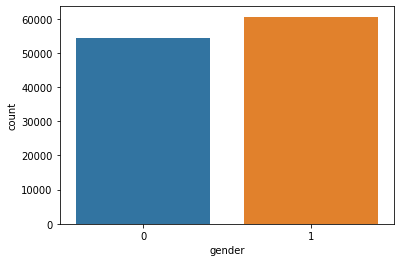

In [92]:
#После перекодирования значения М - мужчина принимает 0, а значение F - женщина принимает значение 1
sns.countplot(cr_df2['gender']);

In [93]:
#Посмотрим на остальные категориальные признаки
list(cr_df2.select_dtypes(include = 'object'))

['marital_status', 'job_position', 'tariff_id', 'education', 'living_region']

## Обработка признака marital_status

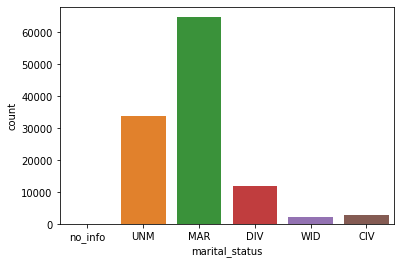

In [94]:
#Признак marital_status можно будет также обработать one-hot
sns.countplot(cr_df2['marital_status']);

Мы видим основные типы семейного статуса:
    - UNM - не состоит в браке
    - MAR - состоит в браке
    - DIV - разведен/на
    - WID - вдова/вдовец
    - CIV - гражданский брак

## Обработка признака job_position

In [95]:
cr_df2['job_position'].value_counts(dropna = False)

SPC    93090
UMN    11378
BIS     3220
PNA     2495
DIR     1896
ATP     1849
WRK      372
NOR      267
WOI      194
INP       88
WRP       54
BIU       45
PNI       28
PNV       25
HSK        7
INV        3
PNS        2
Name: job_position, dtype: int64

In [96]:
#Обозначим указанные категории как other, так как они относительно небольшие
cr_df2.at[cr_df2['job_position'].isin(['WRP','BIU','PNI', 'PNV', 'HSK', 'INV', 'PNS']), 'job_position'] = 'OTHER'

In [97]:
cr_df2['job_position'].value_counts(dropna = False)

SPC      93090
UMN      11378
BIS       3220
PNA       2495
DIR       1896
ATP       1849
WRK        372
NOR        267
WOI        194
OTHER      164
INP         88
Name: job_position, dtype: int64

## Обработка признака tariff_id

In [98]:
#Выведем частоты категории tariff_id
cr_df2['tariff_id'].value_counts()

1.1     46999
1.6     25713
1.32    13387
1.4      6866
1.5      4227
1.9      2799
1.43     2770
1.16     2512
1.3      1850
1.19     1630
1.44     1167
1.0      1097
1.7       605
1.20      601
1.17      568
1.21      470
1.94      282
1.22      280
1.23      273
1.91      266
1.24      242
1.2       208
1.41      109
1.25       43
1.26       10
1.28       10
1.18        8
1.27        6
1.52        6
1.48        5
1.56        2
1.96        1
1.29        1
Name: tariff_id, dtype: int64

In [99]:
#Для всех значений с частотой менее 42 создадим отдельную категорию 1.99
cr_df2.loc[cr_df2['tariff_id'].value_counts()[cr_df2['tariff_id']].values < 42, 'tariff_id'] = 1.99

In [100]:
cr_df2['tariff_id'].value_counts()

1.1     46999
1.6     25713
1.32    13387
1.4      6866
1.5      4227
1.9      2799
1.43     2770
1.16     2512
1.3      1850
1.19     1630
1.44     1167
1.0      1097
1.7       605
1.20      601
1.17      568
1.21      470
1.94      282
1.22      280
1.23      273
1.91      266
1.24      242
1.2       208
1.41      109
1.99       49
1.25       43
Name: tariff_id, dtype: int64

In [101]:
#Изменим наименование тарифов заменив точки на нижнее подчеркивание
cr_df2['tariff_id'] = cr_df2['tariff_id'].astype('str').str.replace('.', '_')

In [102]:
#Выведем частоты и посмотрим что получилось
cr_df2['tariff_id'].value_counts()

1_1     46999
1_6     25713
1_32    13387
1_4      6866
1_5      4227
1_9      2799
1_43     2770
1_16     2512
1_3      1850
1_19     1630
1_44     1167
1_0      1097
1_7       605
1_20      601
1_17      568
1_21      470
1_94      282
1_22      280
1_23      273
1_91      266
1_24      242
1_2       208
1_41      109
1_99       49
1_25       43
Name: tariff_id, dtype: int64

## Дообработка признака living_region

In [103]:
#Посмотрим на последние значения данного признака, которые встречаются реже всего
cr_df2['living_region'].value_counts().tail(10)

ЕВРЕЙСКАЯ      134
no_info        129
НЕНЕЦКИЙ       106
МАГАДАНСКАЯ     75
ДАГЕСТАН        44
АЛТАЙ           32
ЧУКОТСКИЙ       17
ЧИТИНСКАЯ       12
ЧЕЧЕНСКАЯ       11
ИНГУШЕТИЯ       10
Name: living_region, dtype: int64

In [104]:
#Создадим объект Series, который будет содержать в себе частоты значений признака living_region
regions_series = cr_df2['living_region'].value_counts()

In [105]:
region_frequency = regions_series / regions_series.sum() * 100

In [106]:
region_frequency

МОСКОВСКАЯ               6.909654
КРАСНОДАРСКИЙ            4.869884
ТАТАРСТАН                4.815108
СВЕРДЛОВСКАЯ             4.527314
САНКТ-ПЕТЕРБУРГ          4.495144
МОСКВА                   4.040413
БАШКОРТОСТАН             3.838696
ЧЕЛЯБИНСКАЯ              3.243981
САМАРСКАЯ                2.853590
СТАВРОПОЛЬСКИЙ           2.744038
РОСТОВСКАЯ               2.604053
ИРКУТСКАЯ                2.601445
ХАНТЫ-МАНСИЙСКИЙ         2.515368
НИЖЕГОРОДСКАЯ            2.299740
ПЕРМСКИЙ                 2.187579
ЛЕНИНГРАДСКАЯ            2.095415
КРАСНОЯРСКИЙ             1.859790
КЕМЕРОВСКАЯ              1.738064
АСТРАХАНСКАЯ             1.632859
ВОЛГОГРАДСКАЯ            1.545912
ВОЛОГОДСКАЯ              1.435490
САРАТОВСКАЯ              1.434620
ТЮМЕНСКАЯ                1.432012
НОВОСИБИРСКАЯ            1.177258
КОМИ                     1.141610
ВОРОНЕЖСКАЯ              1.085095
ЯМАЛО-НЕНЕЦКИЙ           1.041621
ВЛАДИМИРСКАЯ             0.999018
ТВЕРСКАЯ                 0.972064
АРХАНГЕЛЬСКАЯ 

In [107]:
#Создадим маску, которая будет принимать значение True если частота меньше чем 0.027
region_mask = region_frequency.lt(0.027)

In [108]:
region_mask.tail(10)

ЕВРЕЙСКАЯ      False
no_info        False
НЕНЕЦКИЙ       False
МАГАДАНСКАЯ    False
ДАГЕСТАН       False
АЛТАЙ          False
ЧУКОТСКИЙ       True
ЧИТИНСКАЯ       True
ЧЕЧЕНСКАЯ       True
ИНГУШЕТИЯ       True
Name: living_region, dtype: bool

In [109]:
#Для всех регионов со значением True поставим OTHER
cr_df2['living_region'] = np.where(cr_df2['living_region'].isin(regions_series[region_mask].index), 
                                   'OTHER', cr_df2['living_region'])

In [110]:
cr_df2['living_region'].value_counts().tail(10)

СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ    240
КАМЧАТСКИЙ               212
КАЛМЫКИЯ                 195
ЕВРЕЙСКАЯ                134
no_info                  129
НЕНЕЦКИЙ                 106
МАГАДАНСКАЯ               75
OTHER                     50
ДАГЕСТАН                  44
АЛТАЙ                     32
Name: living_region, dtype: int64

In [111]:
list(cr_df2.select_dtypes(include = object))

['marital_status', 'job_position', 'tariff_id', 'education', 'living_region']

## Обработка признака education

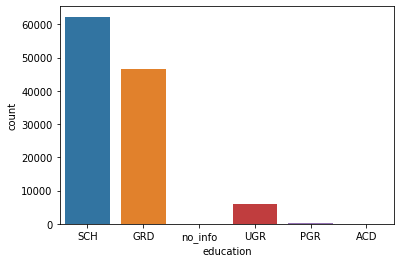

In [112]:
sns.countplot(cr_df2['education']);

In [113]:
cr_df2['education'].value_counts()
#В последствие можно будет применить one-hot кодирование

SCH        62285
GRD        46598
UGR         5858
PGR          229
ACD           41
no_info        2
Name: education, dtype: int64

In [114]:
cr_df2.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
4,5,0,45.0,no_info,SPC,-999.0,10,1_1,0.421385,SCH,ЧЕЛЯБИНСКАЯ,-999.0,1.0,0.0,0
7,8,1,26.0,UNM,SPC,47878.0,10,1_1,0.512525,GRD,МОСКОВСКАЯ,60000.0,3.0,0.0,0
10,11,0,26.0,MAR,SPC,16793.0,14,1_0,0.445430,SCH,САНКТ-ПЕТЕРБУРГ,36000.0,2.0,0.0,0
11,12,1,26.0,UNM,SPC,18936.0,10,1_32,0.455774,no_info,БАШКОРТОСТАН,30000.0,0.0,0.0,0
12,13,0,37.0,MAR,SPC,42289.0,10,1_6,0.691609,SCH,АРХАНГЕЛЬСКАЯ,70000.0,1.0,0.0,0


# Конструирование новых признаков

In [115]:
#Необходимо создать отдельные признаки - идентификаторы пропусков

In [116]:
#Посмотрим на исходный "грязный" датафрейм
cr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 15 columns):
client_id               170746 non-null int64
gender                  170746 non-null object
age                     170743 non-null float64
marital_status          170743 non-null object
job_position            170746 non-null object
credit_sum              170744 non-null float64
credit_month            170746 non-null int64
tariff_id               170746 non-null object
score_shk               170739 non-null float64
education               170741 non-null object
living_region           170554 non-null object
monthly_income          170741 non-null float64
credit_count            161516 non-null float64
overdue_credit_count    161516 non-null float64
open_account_flg        170746 non-null int64
dtypes: float64(6), int64(3), object(6)
memory usage: 19.5+ MB


In [117]:
#Пропущенные числовые значения были заполнены -999, теперь необходимо создать отдельный признак, 
#который бы являлся неким флагом, символизирующем о том, что в наблюдении по признаку стоит -999.

#начнем с обработки признака age
cr_df2['no_age_info'] = cr_df2.age.map(lambda x: 1 if x == -999 else 0)

In [118]:
#Проверим на наличие индентификатора пропущенного значения в признаке credit_sum
cr_df2['credit_sum'].min()

-999.0

In [119]:
#Есть всего лишь одно наблюдение с идентификатором -999 по признаку credit_sum
cr_df2[cr_df2['credit_sum']==-999]

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg,no_age_info
4,5,0,45.0,no_info,SPC,-999.0,10,1_1,0.421385,SCH,ЧЕЛЯБИНСКАЯ,-999.0,1.0,0.0,0,0


In [120]:
cr_df2['no_creditsum_info'] = cr_df2.credit_sum.map(lambda x: 1 if x == -999 else 0)

In [121]:
cr_df2[cr_df2['no_creditsum_info']==1]

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg,no_age_info,no_creditsum_info
4,5,0,45.0,no_info,SPC,-999.0,10,1_1,0.421385,SCH,ЧЕЛЯБИНСКАЯ,-999.0,1.0,0.0,0,0,1


In [122]:
cr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 15 columns):
client_id               170746 non-null int64
gender                  170746 non-null object
age                     170743 non-null float64
marital_status          170743 non-null object
job_position            170746 non-null object
credit_sum              170744 non-null float64
credit_month            170746 non-null int64
tariff_id               170746 non-null object
score_shk               170739 non-null float64
education               170741 non-null object
living_region           170554 non-null object
monthly_income          170741 non-null float64
credit_count            161516 non-null float64
overdue_credit_count    161516 non-null float64
open_account_flg        170746 non-null int64
dtypes: float64(6), int64(3), object(6)
memory usage: 19.5+ MB


In [123]:
cr_df2[cr_df2['monthly_income']==-999]

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg,no_age_info,no_creditsum_info
4,5,0,45.0,no_info,SPC,-999.0,10,1_1,0.421385,SCH,ЧЕЛЯБИНСКАЯ,-999.0,1.0,0.0,0,0,1
19639,19640,1,33.0,MAR,BIS,13009.0,10,1_6,0.535834,SCH,ПРИМОРСКИЙ,-999.0,2.0,0.0,0,0,0


In [124]:
cr_df2['no_monthlyincome_info'] = cr_df2.monthly_income.map(lambda x: 1 if x == -999 else 0)

In [125]:
cr_df2[cr_df2['no_monthlyincome_info']==1]

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg,no_age_info,no_creditsum_info,no_monthlyincome_info
4,5,0,45.0,no_info,SPC,-999.0,10,1_1,0.421385,SCH,ЧЕЛЯБИНСКАЯ,-999.0,1.0,0.0,0,0,1,1
19639,19640,1,33.0,MAR,BIS,13009.0,10,1_6,0.535834,SCH,ПРИМОРСКИЙ,-999.0,2.0,0.0,0,0,0,1


In [126]:
cr_df2[cr_df2['credit_count']==-999]

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg,no_age_info,no_creditsum_info,no_monthlyincome_info


In [127]:
cr_df2[cr_df2['overdue_credit_count']==-999]

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg,no_age_info,no_creditsum_info,no_monthlyincome_info


In [128]:
cr_df2[cr_df2['open_account_flg']==-999]

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg,no_age_info,no_creditsum_info,no_monthlyincome_info


Таким образом были созданы признаки-флаги по каждому из признаков датафрейма. Если в этом признаке встречается значение -999, которое символизирует о том, что значение ранее было пропущенным, то в соответствующем флаге срабатывает 1.

In [129]:
cr_df2.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg,no_age_info,no_creditsum_info,no_monthlyincome_info
4,5,0,45.0,no_info,SPC,-999.0,10,1_1,0.421385,SCH,ЧЕЛЯБИНСКАЯ,-999.0,1.0,0.0,0,0,1,1
7,8,1,26.0,UNM,SPC,47878.0,10,1_1,0.512525,GRD,МОСКОВСКАЯ,60000.0,3.0,0.0,0,0,0,0
10,11,0,26.0,MAR,SPC,16793.0,14,1_0,0.445430,SCH,САНКТ-ПЕТЕРБУРГ,36000.0,2.0,0.0,0,0,0,0
11,12,1,26.0,UNM,SPC,18936.0,10,1_32,0.455774,no_info,БАШКОРТОСТАН,30000.0,0.0,0.0,0,0,0,0
12,13,0,37.0,MAR,SPC,42289.0,10,1_6,0.691609,SCH,АРХАНГЕЛЬСКАЯ,70000.0,1.0,0.0,0,0,0,0


In [130]:
cr_df2_copy = cr_df2.copy(deep=True)

In [131]:
dummies_cr_df2 = pd.get_dummies(cr_df2)

In [132]:
dummies_cr_df2.shape

(115013, 143)

In [133]:
pd.set_option('display.max_columns', 150)

In [134]:
dummies_cr_df2.head()

,client_id,gender,age,credit_sum,credit_month,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg,no_age_info,no_creditsum_info,no_monthlyincome_info,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID,marital_status_no_info,job_position_ATP,job_position_BIS,job_position_DIR,job_position_INP,job_position_NOR,job_position_OTHER,job_position_PNA,job_position_SPC,job_position_UMN,job_position_WOI,job_position_WRK,tariff_id_1_0,tariff_id_1_1,tariff_id_1_16,tariff_id_1_17,tariff_id_1_19,tariff_id_1_2,tariff_id_1_20,tariff_id_1_21,tariff_id_1_22,tariff_id_1_23,tariff_id_1_24,tariff_id_1_25,tariff_id_1_3,tariff_id_1_32,tariff_id_1_4,tariff_id_1_41,tariff_id_1_43,tariff_id_1_44,tariff_id_1_5,tariff_id_1_6,tariff_id_1_7,tariff_id_1_9,tariff_id_1_91,tariff_id_1_94,tariff_id_1_99,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,education_no_info,living_region_OTHER,living_region_no_info,living_region_АДЫГЕЯ,living_region_АЛТАЙ,living_region_АЛТАЙСКИЙ,living_region_АМУРСКАЯ,living_region_АРХАНГЕЛЬСКАЯ,living_region_АСТРАХАНСКАЯ,living_region_БАШКОРТОСТАН,living_region_БЕЛГОРОДСКАЯ,living_region_БРЯНСКАЯ,living_region_БУРЯТИЯ,living_region_ВЛАДИМИРСКАЯ,living_region_ВОЛГОГРАДСКАЯ,living_region_ВОЛОГОДСКАЯ,living_region_ВОРОНЕЖСКАЯ,living_region_ДАГЕСТАН,living_region_ЕВРЕЙСКАЯ,living_region_ЗАБАЙКАЛЬСКИЙ,living_region_ИВАНОВСКАЯ,living_region_ИРКУТСКАЯ,living_region_КАБАРДИНО-БАЛКАРСКАЯ,living_region_КАЛИНИНГРАДСКАЯ,living_region_КАЛМЫКИЯ,living_region_КАЛУЖСКАЯ,living_region_КАМЧАТСКИЙ,living_region_КАРАЧАЕВО-ЧЕРКЕССКАЯ,living_region_КАРЕЛИЯ,living_region_КЕМЕРОВСКАЯ,living_region_КИРОВСКАЯ,living_region_КОМИ,living_region_КОСТРОМСКАЯ,living_region_КРАСНОДАРСКИЙ,living_region_КРАСНОЯРСКИЙ,living_region_КУРГАНСКАЯ,living_region_КУРСКАЯ,living_region_ЛЕНИНГРАДСКАЯ,living_region_ЛИПЕЦКАЯ,living_region_МАГАДАНСКАЯ,living_region_МАРИЙЭЛ,living_region_МОРДОВИЯ,living_region_МОСКВА,living_region_МОСКОВСКАЯ,living_region_МУРМАНСКАЯ,living_region_НЕНЕЦКИЙ,living_region_НИЖЕГОРОДСКАЯ,living_region_НОВГОРОДСКАЯ,living_region_НОВОСИБИРСКАЯ,living_region_ОМСКАЯ,living_region_ОРЕНБУРГСКАЯ,living_region_ОРЛОВСКАЯ,living_region_ПЕНЗЕНСКАЯ,living_region_ПЕРМСКИЙ,living_region_ПРИМОРСКИЙ,living_region_ПСКОВСКАЯ,living_region_РОСТОВСКАЯ,living_region_РЯЗАНСКАЯ,living_region_САМАРСКАЯ,living_region_САНКТ-ПЕТЕРБУРГ,living_region_САРАТОВСКАЯ,living_region_САХА/ЯКУТИЯ/,living_region_САХАЛИНСКАЯ,living_region_СВЕРДЛОВСКАЯ,living_region_СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ,living_region_СМОЛЕНСКАЯ,living_region_СТАВРОПОЛЬСКИЙ,living_region_ТАМБОВСКАЯ,living_region_ТАТАРСТАН,living_region_ТВЕРСКАЯ,living_region_ТОМСКАЯ,living_region_ТУЛЬСКАЯ,living_region_ТЫВА,living_region_ТЮМЕНСКАЯ,living_region_УДМУРТСКАЯ,living_region_УЛЬЯНОВСКАЯ,living_region_ХАБАРОВСКИЙ,living_region_ХАКАСИЯ,living_region_ХАНТЫ-МАНСИЙСКИЙ,living_region_ЧЕЛЯБИНСКАЯ,living_region_ЧУВАШСКАЯ,living_region_ЯМАЛО-НЕНЕЦКИЙ,living_region_ЯРОСЛАВСКАЯ
4,5,0,45.0,-999.0,10,0.421385,-999.0,1.0,0.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,8,1,26.0,47878.0,10,0.512525,60000.0,3.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,11,0,26.0,16793.0,14,0.445430,36000.0,2.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,12,1,26.0,18936.0,10,0.455774,30000.0,0.0,0.0,0,0

In [135]:
tink_df = dummies_cr_df2.copy(deep = True)

In [136]:
tink_df.head()

,client_id,gender,age,credit_sum,credit_month,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg,no_age_info,no_creditsum_info,no_monthlyincome_info,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID,marital_status_no_info,job_position_ATP,job_position_BIS,job_position_DIR,job_position_INP,job_position_NOR,job_position_OTHER,job_position_PNA,job_position_SPC,job_position_UMN,job_position_WOI,job_position_WRK,tariff_id_1_0,tariff_id_1_1,tariff_id_1_16,tariff_id_1_17,tariff_id_1_19,tariff_id_1_2,tariff_id_1_20,tariff_id_1_21,tariff_id_1_22,tariff_id_1_23,tariff_id_1_24,tariff_id_1_25,tariff_id_1_3,tariff_id_1_32,tariff_id_1_4,tariff_id_1_41,tariff_id_1_43,tariff_id_1_44,tariff_id_1_5,tariff_id_1_6,tariff_id_1_7,tariff_id_1_9,tariff_id_1_91,tariff_id_1_94,tariff_id_1_99,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,education_no_info,living_region_OTHER,living_region_no_info,living_region_АДЫГЕЯ,living_region_АЛТАЙ,living_region_АЛТАЙСКИЙ,living_region_АМУРСКАЯ,living_region_АРХАНГЕЛЬСКАЯ,living_region_АСТРАХАНСКАЯ,living_region_БАШКОРТОСТАН,living_region_БЕЛГОРОДСКАЯ,living_region_БРЯНСКАЯ,living_region_БУРЯТИЯ,living_region_ВЛАДИМИРСКАЯ,living_region_ВОЛГОГРАДСКАЯ,living_region_ВОЛОГОДСКАЯ,living_region_ВОРОНЕЖСКАЯ,living_region_ДАГЕСТАН,living_region_ЕВРЕЙСКАЯ,living_region_ЗАБАЙКАЛЬСКИЙ,living_region_ИВАНОВСКАЯ,living_region_ИРКУТСКАЯ,living_region_КАБАРДИНО-БАЛКАРСКАЯ,living_region_КАЛИНИНГРАДСКАЯ,living_region_КАЛМЫКИЯ,living_region_КАЛУЖСКАЯ,living_region_КАМЧАТСКИЙ,living_region_КАРАЧАЕВО-ЧЕРКЕССКАЯ,living_region_КАРЕЛИЯ,living_region_КЕМЕРОВСКАЯ,living_region_КИРОВСКАЯ,living_region_КОМИ,living_region_КОСТРОМСКАЯ,living_region_КРАСНОДАРСКИЙ,living_region_КРАСНОЯРСКИЙ,living_region_КУРГАНСКАЯ,living_region_КУРСКАЯ,living_region_ЛЕНИНГРАДСКАЯ,living_region_ЛИПЕЦКАЯ,living_region_МАГАДАНСКАЯ,living_region_МАРИЙЭЛ,living_region_МОРДОВИЯ,living_region_МОСКВА,living_region_МОСКОВСКАЯ,living_region_МУРМАНСКАЯ,living_region_НЕНЕЦКИЙ,living_region_НИЖЕГОРОДСКАЯ,living_region_НОВГОРОДСКАЯ,living_region_НОВОСИБИРСКАЯ,living_region_ОМСКАЯ,living_region_ОРЕНБУРГСКАЯ,living_region_ОРЛОВСКАЯ,living_region_ПЕНЗЕНСКАЯ,living_region_ПЕРМСКИЙ,living_region_ПРИМОРСКИЙ,living_region_ПСКОВСКАЯ,living_region_РОСТОВСКАЯ,living_region_РЯЗАНСКАЯ,living_region_САМАРСКАЯ,living_region_САНКТ-ПЕТЕРБУРГ,living_region_САРАТОВСКАЯ,living_region_САХА/ЯКУТИЯ/,living_region_САХАЛИНСКАЯ,living_region_СВЕРДЛОВСКАЯ,living_region_СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ,living_region_СМОЛЕНСКАЯ,living_region_СТАВРОПОЛЬСКИЙ,living_region_ТАМБОВСКАЯ,living_region_ТАТАРСТАН,living_region_ТВЕРСКАЯ,living_region_ТОМСКАЯ,living_region_ТУЛЬСКАЯ,living_region_ТЫВА,living_region_ТЮМЕНСКАЯ,living_region_УДМУРТСКАЯ,living_region_УЛЬЯНОВСКАЯ,living_region_ХАБАРОВСКИЙ,living_region_ХАКАСИЯ,living_region_ХАНТЫ-МАНСИЙСКИЙ,living_region_ЧЕЛЯБИНСКАЯ,living_region_ЧУВАШСКАЯ,living_region_ЯМАЛО-НЕНЕЦКИЙ,living_region_ЯРОСЛАВСКАЯ
4,5,0,45.0,-999.0,10,0.421385,-999.0,1.0,0.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,8,1,26.0,47878.0,10,0.512525,60000.0,3.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,11,0,26.0,16793.0,14,0.445430,36000.0,2.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,12,1,26.0,18936.0,10,0.455774,30000.0,0.0,0.0,0,0

# Разбиение на обучающую и тестовую выборку

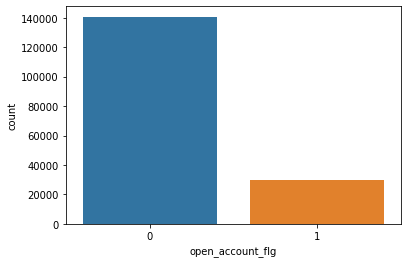

In [137]:
sns.countplot(cr_df['open_account_flg']);

In [138]:
cr_df['open_account_flg'].value_counts()

0    140690
1     30056
Name: open_account_flg, dtype: int64

Объектов класса 0 гораздо больше, чем объектов класса 1. Поэтому при дальнейшем построении модели это нужно учитывать, иначе будет необъективное качество точности и полноты.

In [139]:
cr_df.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,NaN,NaN,UMN,59998.00,10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,NaN,MAR,UMN,10889.00,6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,3,M,32.0,MAR,SPC,10728.00,12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,4,F,27.0,NaN,SPC,12009.09,12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,5,M,45.0,NaN,SPC,NaN,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0


In [140]:
cr_df.shape

(170746, 15)

In [141]:
tink_df.to_csv("tinkoff_dataframe")

# ВНИМАНИЕ! Дальнейшее изложение кода в текущем нотбуке черновое, вы конечно можете посмотреть его, если интересно, но для просмотра чистового варианта прошу перейти в нотбук "Models on Tinkoff", который расположен в том же репозитории. Спасибо)

In [142]:
tink_df.head()

,client_id,gender,age,credit_sum,credit_month,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg,no_age_info,no_creditsum_info,no_monthlyincome_info,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID,marital_status_no_info,job_position_ATP,job_position_BIS,job_position_DIR,job_position_INP,job_position_NOR,job_position_OTHER,job_position_PNA,job_position_SPC,job_position_UMN,job_position_WOI,job_position_WRK,tariff_id_1_0,tariff_id_1_1,tariff_id_1_16,tariff_id_1_17,tariff_id_1_19,tariff_id_1_2,tariff_id_1_20,tariff_id_1_21,tariff_id_1_22,tariff_id_1_23,tariff_id_1_24,tariff_id_1_25,tariff_id_1_3,tariff_id_1_32,tariff_id_1_4,tariff_id_1_41,tariff_id_1_43,tariff_id_1_44,tariff_id_1_5,tariff_id_1_6,tariff_id_1_7,tariff_id_1_9,tariff_id_1_91,tariff_id_1_94,tariff_id_1_99,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,education_no_info,living_region_OTHER,living_region_no_info,living_region_АДЫГЕЯ,living_region_АЛТАЙ,living_region_АЛТАЙСКИЙ,living_region_АМУРСКАЯ,living_region_АРХАНГЕЛЬСКАЯ,living_region_АСТРАХАНСКАЯ,living_region_БАШКОРТОСТАН,living_region_БЕЛГОРОДСКАЯ,living_region_БРЯНСКАЯ,living_region_БУРЯТИЯ,living_region_ВЛАДИМИРСКАЯ,living_region_ВОЛГОГРАДСКАЯ,living_region_ВОЛОГОДСКАЯ,living_region_ВОРОНЕЖСКАЯ,living_region_ДАГЕСТАН,living_region_ЕВРЕЙСКАЯ,living_region_ЗАБАЙКАЛЬСКИЙ,living_region_ИВАНОВСКАЯ,living_region_ИРКУТСКАЯ,living_region_КАБАРДИНО-БАЛКАРСКАЯ,living_region_КАЛИНИНГРАДСКАЯ,living_region_КАЛМЫКИЯ,living_region_КАЛУЖСКАЯ,living_region_КАМЧАТСКИЙ,living_region_КАРАЧАЕВО-ЧЕРКЕССКАЯ,living_region_КАРЕЛИЯ,living_region_КЕМЕРОВСКАЯ,living_region_КИРОВСКАЯ,living_region_КОМИ,living_region_КОСТРОМСКАЯ,living_region_КРАСНОДАРСКИЙ,living_region_КРАСНОЯРСКИЙ,living_region_КУРГАНСКАЯ,living_region_КУРСКАЯ,living_region_ЛЕНИНГРАДСКАЯ,living_region_ЛИПЕЦКАЯ,living_region_МАГАДАНСКАЯ,living_region_МАРИЙЭЛ,living_region_МОРДОВИЯ,living_region_МОСКВА,living_region_МОСКОВСКАЯ,living_region_МУРМАНСКАЯ,living_region_НЕНЕЦКИЙ,living_region_НИЖЕГОРОДСКАЯ,living_region_НОВГОРОДСКАЯ,living_region_НОВОСИБИРСКАЯ,living_region_ОМСКАЯ,living_region_ОРЕНБУРГСКАЯ,living_region_ОРЛОВСКАЯ,living_region_ПЕНЗЕНСКАЯ,living_region_ПЕРМСКИЙ,living_region_ПРИМОРСКИЙ,living_region_ПСКОВСКАЯ,living_region_РОСТОВСКАЯ,living_region_РЯЗАНСКАЯ,living_region_САМАРСКАЯ,living_region_САНКТ-ПЕТЕРБУРГ,living_region_САРАТОВСКАЯ,living_region_САХА/ЯКУТИЯ/,living_region_САХАЛИНСКАЯ,living_region_СВЕРДЛОВСКАЯ,living_region_СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ,living_region_СМОЛЕНСКАЯ,living_region_СТАВРОПОЛЬСКИЙ,living_region_ТАМБОВСКАЯ,living_region_ТАТАРСТАН,living_region_ТВЕРСКАЯ,living_region_ТОМСКАЯ,living_region_ТУЛЬСКАЯ,living_region_ТЫВА,living_region_ТЮМЕНСКАЯ,living_region_УДМУРТСКАЯ,living_region_УЛЬЯНОВСКАЯ,living_region_ХАБАРОВСКИЙ,living_region_ХАКАСИЯ,living_region_ХАНТЫ-МАНСИЙСКИЙ,living_region_ЧЕЛЯБИНСКАЯ,living_region_ЧУВАШСКАЯ,living_region_ЯМАЛО-НЕНЕЦКИЙ,living_region_ЯРОСЛАВСКАЯ
4,5,0,45.0,-999.0,10,0.421385,-999.0,1.0,0.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,8,1,26.0,47878.0,10,0.512525,60000.0,3.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,11,0,26.0,16793.0,14,0.445430,36000.0,2.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,12,1,26.0,18936.0,10,0.455774,30000.0,0.0,0.0,0,0

# Используем подход UnderSampling и обучим RandomForest и LogisticRegression

In [143]:
rus = RandomUnderSampler(random_state=0)

In [144]:
X = cr_df.drop('open_account_flg', axis = 1).values
y = cr_df['open_account_flg'].values
X_resampled, y_resampled = rus.fit_sample(X, y)

ValueError: Input contains NaN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 42)

# Logistic Regression

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

In [ ]:
#Сформируем предсказания логистической регрессии
logreg_pred = logreg.predict(X_test)
#Оценим accuracy на обучабщей и тестовой выборке
logreg_acc_train = logreg.score(X_train, y_train)
logreg_acc_test = logreg.score(X_test, y_test)
print("Logistic Regression accuracy on train:{:.3f}".format(logreg_acc_train))
print("Logistic Regression accuracy on test:{:.3f}".format(logreg_acc_test))

In [ ]:
#Посмотрим на precision & recall на Logistic Regression
print("Precision on LogReg:{:.3f}".format(precision_score(y_test, logreg_pred)))
print("Recall on LogReg:{:.3f}".format(recall_score(y_test, logreg_pred)))

## Подбор параметров логистической регрессии на отмасштабированном датасете

In [ ]:
LogisticRegression?

In [ ]:
logreg_param = {"penalty":['l1', 'l2'],
                "solver": ['liblinear', 'newton-cg', 'sag', 'lbfgs']}

In [ ]:
lr = LogisticRegression()
lr_grids = GridSearchCV(estimator=lr, param_grid=logreg_param)
lr_grids.fit(X2_train, y2_train)

In [ ]:
lr_grids.best_params_

In [ ]:
#Сформируем предсказания логистической регрессии
lr_grids_pred = lr_grids.predict(X2_test)
#Оценим accuracy на обучабщей и тестовой выборке
lr_grids_acc_train = lr_grids.score(X2_train, y2_train)
lr_grids_acc_test = lr_grids.score(X2_test, y2_test)
print("Logistic Regression accuracy on train:{:.3f}".format(lr_grids_acc_train))
print("Logistic Regression accuracy on test:{:.3f}".format(lr_grids_acc_test))

## Попробуем применить StandartScaler а не MinMax

In [ ]:
stsc = StandardScaler()
cr_df_new = cr_df.drop('open_account_flg', axis = 1)
stsc_df = pd.DataFrame(stsc.fit_transform(cr_df_new), index = cr_df_new.index, columns = cr_df_new.columns)

In [ ]:
stsc_df.head()

In [ ]:
X3 = stsc_df.values
y3 = cr_df['open_account_flg'].values
X3_resampled, y3_resampled = rus.fit_sample(X3, y3)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_resampled, y3_resampled, test_size = 0.3, random_state = 42)

In [ ]:
lr_new - L

In [ ]:
lr.fit(X3_train, y3_train)

In [ ]:
print("Logistic Regression accuracy on train:{:.3f}".format(lr.score(X3_train, y3_train)))
print("Logistic Regression accuracy on test:{:.3f}".format(lr.score(X3_test, y3_test)))

# Random Forest

In [ ]:
forest = RandomForestClassifier(n_estimators = 800, max_depth=17, random_state=152, n_jobs=-1, oob_score=True)
forest.fit(X_train, y_train)
#Предскажем метки классов с помощью алгоритма случайного леса
y_forest_pred = forest.predict(X_test)
#Посчитаем accuracy на обучающей и тестовой выборке
acc_forest_train = forest.score(X_train, y_train)
acc_forest_test = forest.score(X_test, y_test)
print("Accuracy RandomForest на обучающей выборке:{:.3f}".format(acc_forest_train))
print("Accuracy RandomForest на тестовой выборке:{:.3f}".format(acc_forest_test))
#Посмотрим на точность и полноту RandomForest
from sklearn.metrics import precision_score, recall_score
print("Precision RandomForest:{}".format(precision_score(list(y_test), list(y_forest_pred))))
print("Recall RandomForest:{}".format(recall_score(list(y_test), list(y_forest_pred))))

In [ ]:
y_scores = forest.predict_proba(X_test)
y_scores = y_scores[:,1]
precision, recall, threshold = precision_recall_curve(y_test, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

In [ ]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(precision, recall)
plt.show()

In [ ]:
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

In [ ]:
false_positive_rate.shape

In [ ]:
true_positive_rate.shape

In [ ]:
print("AUC на обучающей выборке:{:.2f}".format(
    roc_auc_score(y_train, forest.predict_proba(X_train)[:, 1])))
print("AUC на тестовой выборке:{:.2f}".format(
    roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])))

# Измерение качества на кросс-валидации

In [ ]:
cv_train_scores = cross_val_score(forest, X_train, y_train, cv=5, scoring = 'accuracy')
print("Scores:", cv_train_scores)
print("Mean:", cv_train_scores.mean())
print("Standard Deviation:", cv_train_scores.std())

In [ ]:
cv_train_scores = cross_val_score(forest, X_test, y_test, cv=5, scoring = 'accuracy')
print("Scores:", cv_train_scores)
print("Mean:", cv_train_scores.mean())
print("Standard Deviation:", cv_train_scores.std())

# Отмасштабируем данные и посмотрим как изменится качетсво

In [ ]:
mmsc = MinMaxScaler()
mmsc_df = pd.DataFrame(mmsc.fit_transform(cr_df), index = cr_df.index, columns = cr_df.columns)

In [ ]:
mmsc_df.head()

In [ ]:
X2 = mmsc_df.drop('open_account_flg', axis = 1).values
y2 = mmsc_df['open_account_flg'].values
X2_resampled, y2_resampled = rus.fit_sample(X2, y2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_resampled, y2_resampled, test_size = 0.3, random_state = 42)

In [ ]:
#Обучим логистическую регрессию на отмасштабированном датафрейме и посмотрим как изменилось качество 
logreg.fit(X2_train, y2_train)

In [145]:
#Сформируем предсказания логистической регрессии
logreg2_pred = logreg.predict(X2_test)
#Оценим accuracy на обучабщей и тестовой выборке
logreg2_acc_train = logreg.score(X2_train, y2_train)
logreg2_acc_test = logreg.score(X2_test, y2_test)
print("Logistic Regression accuracy on train:{:.3f}".format(logreg2_acc_train))
print("Logistic Regression accuracy on test:{:.3f}".format(logreg2_acc_test))

NameError: name 'logreg' is not defined

In [ ]:
#После того, как было проведено масштабирование датафрейма с помощью MinMaxScaler 
#качество на логистической регрессии повысилось.

#Давайте сформируем табличку чтобы наглядно это увидеть
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Logistic Regression on MinMax df'],
    'Score on test': [logreg_acc_test, logreg2_acc_test]})
#Отсортируем результаты по убыванию, для этого установим параметр "возрастание" в значение False
result_df = results.sort_values(by='Score on test', ascending=False)
#Установим в качестве индекса значение скора модели
result_df = result_df.set_index('Score on test')
result_df

## Проверим изменится ли качество у RandomForest после масштабирования

In [ ]:
forest.fit(X2_train, y2_train)
#Предскажем метки классов с помощью алгоритма случайного леса
y_forest2_pred = forest.predict(X2_test)
#Посчитаем accuracy на обучающей и тестовой выборке
acc_forest2_train = forest.score(X2_train, y2_train)
acc_forest2_test = forest.score(X2_test, y2_test)
print("Accuracy RandomForest2 на обучающей выборке:{:.3f}".format(acc_forest2_train))
print("Accuracy RandomForest2 на тестовой выборке:{:.3f}".format(acc_forest2_test))
#Посмотрим на точность и полноту RandomForest
from sklearn.metrics import precision_score, recall_score
Forest2_precision = precision_score(list(y2_test), list(y_forest2_pred))
Forest2_recall = recall_score(list(y2_test), list(y_forest2_pred))
print("Precision RandomForest2:{}".format(precision_score(list(y2_test), list(y_forest2_pred))))
print("Recall RandomForest2:{}".format(recall_score(list(y2_test), list(y_forest2_pred))))

In [ ]:
Forest_precision = precision_score(list(y_test), list(y_forest_pred))
Forest_recall = recall_score(list(y_test), list(y_forest_pred))

In [ ]:
#Видно что масштабирование никак не повлияло на работу RandomForest, даже немного ухудшило
results = pd.DataFrame({
    'Model': ['Forest', 'Forest2 on MinMax df'],
    'Precision': [Forest_precision, Forest2_precision],
    'Recall': [Forest_recall, Forest2_recall]})
results.set_index('Model')

# Дерево решений

In [ ]:
param_tree = { "criterion" : ["gini", "entropy"], \
              "max_depth":[4,5,8,9,10],
              "min_samples_leaf": [1,5,10,15,25,30],
              "min_samples_split": [2, 4, 10, 12, 16, 18]}

In [ ]:
tree = DecisionTreeClassifier()
tree_gridsearch = GridSearchCV(estimator=tree, param_grid = param_tree)
tree_gridsearch.fit(X_train, y_train)

In [ ]:
tree_gridsearch.best_params_

In [ ]:
tree_pred = tree_gridsearch.predict(X_test)
print("Accuracy on Decision tree train:{:.3f}".format(tree_gridsearch.score(X_train, y_train)))
print("Accuracy on Decision tree test:{:.3f}".format(tree_gridsearch.score(X_test, y_test)))
print("Precision Decision tree:{:.3f}".format(precision_score(y_test, tree_pred)))
print("Recall Decision tree:{:.3f}".format(recall_score(y_test, tree_pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, tree_pred)))

# Реализуем поиск гипермараметров RandomForest

In [ ]:
#Опишем возможные значения гиперпараметров модели случайного леса
param_grid = { "criterion" : ["gini", "entropy"], \
              "min_samples_leaf" : [1, 5, 10, 25, 50, 70], \
              "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], \
              "n_estimators": [100, 200, 400, 600, 800, 1000]}
#Инициализируем лес
rf = RandomForestClassifier()


In [ ]:
grids_rf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1, cv=5)
grids_rf.fit(X_train, y_train)

In [ ]:
first_class = cr_df[cr_df['open_account_flg']==1]

In [ ]:
zero_class = cr_df[cr_df['open_account_flg']==0]

In [ ]:
cr_df.pivot_table('client_id', 'open_account_flg', 'count')

In [ ]:
cr_df = shuffle(cr_df)

In [ ]:
cr_df.head(10)

In [ ]:
#Вернемся к исходному датафрейму cr_df
cr_df = dummies_cr_df2

In [ ]:
cr_df.head()

In [ ]:
X = cr_df.drop('open_account_flg', axis = 1)
y = cr_df['open_account_flg']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
X_train.head()

In [ ]:
y_train.head()

In [ ]:
for i in y_train:
    if i ==1:
     print('!!!')

# Random Forest Classifier

In [ ]:
forest = RandomForestClassifier(n_estimators = 800, max_depth=17, random_state=152, n_jobs=-1, oob_score=True)
forest.fit(X_train, y_train)

In [ ]:
#Предскажем метки классов с помощью алгоритма случайного леса
y_forest_pred = forest.predict(X_test)
#Посчитаем accuracy на обучающей и тестовой выборке
acc_forest_train = forest.score(X_train, y_train)
acc_forest_test = forest.score(X_test, y_test)
print("Accuracy RandomForest на обучающей выборке:{:.3f}".format(acc_forest_train))
print("Accuracy RandomForest на тестовой выборке:{:.3f}".format(acc_forest_test))

In [ ]:
#Посмотрим на точность и полноту RandomForest
from sklearn.metrics import precision_score, recall_score
print("Precision RandomForest:{}".format(precision_score(list(y_test), list(y_forest_pred))))
print("Recall RandomForest:{}".format(recall_score(list(y_test), list(y_forest_pred))))

In [ ]:
print("AUC на обучающей выборке:{:.2f}".format(
    roc_auc_score(y_train, forest.predict_proba(X_train)[:, 1])))
print("AUC на тестовой выборке:{:.2f}".format(
    roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])))

In [ ]:
type(y_test)

In [ ]:
0 in y_forest_pred

# Logistic Regression

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

In [ ]:
#Сформируем предсказания логистической регрессии
logreg_pred = logreg.predict(X_test)
#Оценим accuracy на обучабщей и тестовой выборке
logreg_acc_train = logreg.score(X_train, y_train)
logreg_acc_test = logreg.score(X_test, y_test)
print("Logistic Regression accuracy on train:{:.3f}".format(logreg_acc_train))
print("Logistic Regression accuracy on test:{:.3f}".format(logreg_acc_test))

In [ ]:
#Посмотрим на precision & recall на Logistic Regression
print("Precision on LogReg:{:.3f}".format(precision_score(y_test, logreg_pred)))
print("Recall on LogReg:{:.3f}".format(recall_score(y_test, logreg_pred)))

In [ ]:
print('AUC logreg на обучающей выборке:{:.4f}'.format(roc_auc_score(y_train, logreg.predict_proba(X_train)[:,1])))
print('AUC logreg на контрольной выборке:{:.4f}'.format(roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])))

## Масштабирование данных с помощью MinMaxScaler

In [ ]:
#Отмасштабируем данные с помощью MibMaxScaler и Standart Scaler, после чего оценим как изменилось качество.
mmsc = MinMaxScaler()
mmsc_df = pd.DataFrame(mmsc.fit_transform(cr_df), index = cr_df.index, columns = cr_df.columns)

In [ ]:
mmsc_df.head()

In [ ]:
mmsc_df_X = mmsc_df.drop('open_account_flg', axis = 1)
mmsc_df_y = mmsc_df['open_account_flg']

In [ ]:
mmsc_df_X.head()

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(mmsc_df_X, mmsc_df_y, test_size =0.3, random_state = 42)

In [ ]:
logreg.fit(X2_train, y2_train)

In [ ]:
#После масштабирования данных результат логистической регрессии на контрольной выборке повысился
print('AUC logreg на обучающей выборке:{:.4f}'.format(roc_auc_score(y2_train, logreg.predict_proba(X2_train)[:,1])))
print('AUC logreg на контрольной выборке:{:.4f}'.format(roc_auc_score(y2_test, logreg.predict_proba(X2_test)[:,1])))

In [ ]:
#Посмотрим на результат RandomForestClassifier 
forest.fit(X2_train, y2_train)

In [ ]:
print("AUC на обучающей выборке:{:.2f}".format(
    roc_auc_score(y2_train, forest.predict_proba(X2_train)[:, 1])))
print("AUC на тестовой выборке:{:.2f}".format(
    roc_auc_score(y2_test, forest.predict_proba(X2_test)[:, 1])))

## Масштабирование данных с помощью StandartScaler

In [ ]:
stsc = StandardScaler()
stsc_df = pd.DataFrame(stsc.fit_transform(cr_df), index = cr_df.index, columns = cr_df.columns)

In [ ]:
stsc_X = stsc_df.drop('open_account_flg', axis = 1)
stsc_y = stsc_df['open_account_flg']
X3_train, X3_test, y3_train, y3_test = train_test_split(stsc_X, stsc_y, test_size = 0.3, random_state =42)

In [ ]:
logreg.fit(X3_train, y3_train)


In [ ]:
df4_numeric = df4.drop(['gender', 'marital_status', 'job_position', 'tariff_id', 'education', 'living_region'], axis = 1)

In [ ]:
df4_numeric.head()

In [ ]:
sns.countplot(df4_numeric['overdue_credit_count']);

In [ ]:
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(uniform_data, vmin=-1, vmax=1)

In [ ]:
uniform_data.head()

In [ ]:
sns.heatmap?

In [ ]:
cr_df2_numeric = cr_df2.drop(['gender', 'marital_status', 'job_position', 'tariff_id', 'education', 'living_region'], axis = 1)

In [ ]:
#Посмотрим на корреляцию признаков в исходном датафрейме cr_df2, используем корреляцию Спирмена т.к. в наших данных есть выбросы и нужно нивелировать их воздействие.
sns.heatmap(data = cr_df2_numeric.corr(method = 'spearman'));

In [ ]:
sns.jointplot(x = cr_df2['monthly_income'], y = cr_df2['credit_sum'], kind = 'kde');

In [ ]:
sns.heatmap(data = df4_numeric.corr(method = 'pearson'));

In [ ]:
sns.jointplot(x = df4['monthly_income'], y = df4['credit_sum'], kind = 'kde');

In [ ]:
sns.jointplot(x = df4['monthly_income'], y = df4['score_shk'], kind = 'kde');

In [ ]:
sns.jointplot(x = df4['age'], y = df4['credit_sum'], kind = 'kde');

In [ ]:
sns.hist(df4['score_shk']);

In [ ]:
#В России всего 85 субъектов, таким образом количество уникальных значений в столбце living_region не должно превышать 85. 
#Проверим, 301 уникальное значение, с этим необходимо поработать.
cr_df2['living_region'].nunique()

In [ ]:
#Увеличим количество отображаемых строк
pd.options.display.max_rows = 310

In [ ]:
regions = cr_df2['living_region'].unique()

In [ ]:
type(regions)

In [ ]:
regions = pd.Series(data=regions)

In [ ]:
type(regions)

In [ ]:
print(regions)

In [ ]:
import re
x = re.sub('[.,]+', ' ', str(regions))

In [ ]:
data_without_outliers = df_copy[(df_copy['age']< 65.5)&(df_copy['credit_sum']<57808)
                                & (df_copy['monthly_income']>87500)&(df_copy['credit_count']<6)
                                &(df_copy['overdue_credit_count'] == 0)]

In [ ]:
data_without_outliers = df_copy[

In [ ]:
clean_credit_sum = pd.DataFrame(cr_df['credit_sum'].fillna(cr_df['credit_sum'].median()))

In [ ]:
clean_credit_sum.head()

In [ ]:
sns.boxplot(clean_credit_sum);

In [ ]:
quartiles(clean_credit_sum)

In [ ]:
cr_df = cr_df[cr_df['credit_sum']>57909.0]

In [ ]:
cr_df.info()

In [ ]:
df_copy[df_copy['monthly_income']>87500].count()